<a href="https://colab.research.google.com/github/fedhere/MLTSA22_FBianco/blob/main/CodeExamples/sound_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You will need a few unusual libraries

In [ ]:
!pip install python_speech_features
!pip install PyGithub
!pip install pydub

In [ ]:
#system options you will need
import sys
import os
import numpy as np
import glob as glob

import scipy.io.wavfile as wav
from python_speech_features import mfcc
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from scipy.spatial.distance import cdist, euclidean
from scipy.spatial import distance_matrix

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
np.set_printoptions(threshold=sys.maxsize)
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Accessing data

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My\ Drive/MLTSA22/


/content/gdrive/My Drive/MLTSA22


In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
cd data

/content/gdrive/My Drive/MLTSA22/data


## I am going to download data from someone's github repo
One of you asked me earlier in the semester how one would so this. We will use data from Salika Dave, a student at Mumbai tech who stored some soundbites on her GitHub repo.

In [ ]:
from github import Github
# First create a Github instance:
# we do not need to use username and password because we will access a public repo
g = Github()



In [ ]:
guser = g.get_user("salik-a")
repo = guser.get_repo("Speech_Recognition")


In [ ]:
wavfiles = repo.get_contents("voices")
#.repos_url#("Speech_Recognition")
wavfiles

[ContentFile(path="voices/Jarvis_template.wav"),
 ContentFile(path="voices/Jarvisd_template.wav"),
 ContentFile(path="voices/Jarvise_template.wav"),
 ContentFile(path="voices/Jarvish_template.wav"),
 ContentFile(path="voices/Jarvisu_template.wav"),
 ContentFile(path="voices/Tofftl_template.wav"),
 ContentFile(path="voices/Tofftld_template.wav"),
 ContentFile(path="voices/Tofftle_template.wav"),
 ContentFile(path="voices/Tofftlh_template.wav"),
 ContentFile(path="voices/Tofftlu_template.wav"),
 ContentFile(path="voices/Tontl_template.wav"),
 ContentFile(path="voices/Tontld_template.wav"),
 ContentFile(path="voices/Tontle_template.wav"),
 ContentFile(path="voices/Tontlh_template.wav"),
 ContentFile(path="voices/Tontlu_template.wav"),
 ContentFile(path="voices/Tontt_template.wav"),
 ContentFile(path="voices/Tonttd_template.wav"),
 ContentFile(path="voices/Tontte_template.wav"),
 ContentFile(path="voices/Tontth_template.wav"),
 ContentFile(path="voices/Tonttu_template.wav"),
 ContentFile(p

In [ ]:
path = "https://raw.githubusercontent.com/salik-a/Speech_Recognition/master/"
for f in wavfiles:
    cmd = "wget " + "%s/%s"%(path,f.path)
    os.system(cmd)

In [ ]:
%ls

Jarvisd_template.wav    Tofftl_template.wav.1   Tontth_template.wav
Jarvisd_template.wav.1  Tofftlu_template.wav    Tontth_template.wav.1
Jarvise_template.wav    Tofftlu_template.wav.1  Tontt_template.wav
Jarvise_template.wav.1  Tontld_template.wav     Tontt_template.wav.1
Jarvish_template.wav    Tontld_template.wav.1   Tonttu_template.wav
Jarvish_template.wav.1  Tontle_template.wav     Tonttu_template.wav.1
Jarvis_template.wav     Tontle_template.wav.1   Ttatd_template.wav
Jarvis_template.wav.1   Tontlh_template.wav     Ttatd_template.wav.1
Jarvisu_template.wav    Tontlh_template.wav.1   Ttate_template.wav
Jarvisu_template.wav.1  Tontl_template.wav      Ttate_template.wav.1
Tofftld_template.wav    Tontl_template.wav.1    Ttath_template.wav
Tofftld_template.wav.1  Tontlu_template.wav     Ttath_template.wav.1
Tofftle_template.wav    Tontlu_template.wav.1   Ttat_template.wav
Tofftle_template.wav.1  Tonttd_template.wav     Ttat_template.wav.1
Tofftlh_template.wav    Tonttd_template.wav.1 

In [ ]:
cd ../

/content/gdrive/MyDrive/MLTSA22


In [ ]:
filenames = np.sort(glob.glob("data/*wav"))
norm_obj= Normalize(vmin=0, vmax=4)
colors = {"Jarvis": (pl.cm.viridis(norm_obj(0)),
                     "Jarvis"),
         "Tofftl": (pl.cm.viridis(norm_obj(1)),
                    "Turn off the lights"),
         "Tontl": (pl.cm.viridis(norm_obj(2)),
                   "Turn on the lights"),
         "Tontt": (pl.cm.viridis(norm_obj(3)),
                   "Turn on the TV"),
         "Ttat": (pl.cm.viridis(norm_obj(4)),
                  "Turn the air temperature")}
y = np.array([[k for k,v in colors.items() for i in range(5)]])[0]
y

array(['Jarvis', 'Jarvis', 'Jarvis', 'Jarvis', 'Jarvis', 'Tofftl',
       'Tofftl', 'Tofftl', 'Tofftl', 'Tofftl', 'Tontl', 'Tontl', 'Tontl',
       'Tontl', 'Tontl', 'Tontt', 'Tontt', 'Tontt', 'Tontt', 'Tontt',
       'Ttat', 'Ttat', 'Ttat', 'Ttat', 'Ttat'], dtype='<U6')

In [ ]:
for k,v in colors.items():
        print(k,v)

Jarvis ((0.267004, 0.004874, 0.329415, 1.0), 'Jarvis')
Tofftl ((0.229739, 0.322361, 0.545706, 1.0), 'Turn off the lights')
Tontl ((0.127568, 0.566949, 0.550556, 1.0), 'Turn on the lights')
Tontt ((0.369214, 0.788888, 0.382914, 1.0), 'Turn on the TV')
Ttat ((0.993248, 0.906157, 0.143936, 1.0), 'Turn the air temperature')


## Data Exploration and Visualization 
## plot the sound bites
the sound bites are read in as numpy array by the ```scipy.io.wavfile``` module. The dataset is comprised of 5 soundbites for each of 5 sentences. The word "Jarvis", the sentences "Turn off the lights", "Turn on the lights", "Turn on the TV", and "Turn the air temperature". Each sound bite, for each sentence, is read by a different person, with different accents, genders, and background noise. if you install the pydub  module and run the notebook locally you can hear each soundbite in this loop (wont play on google colab).

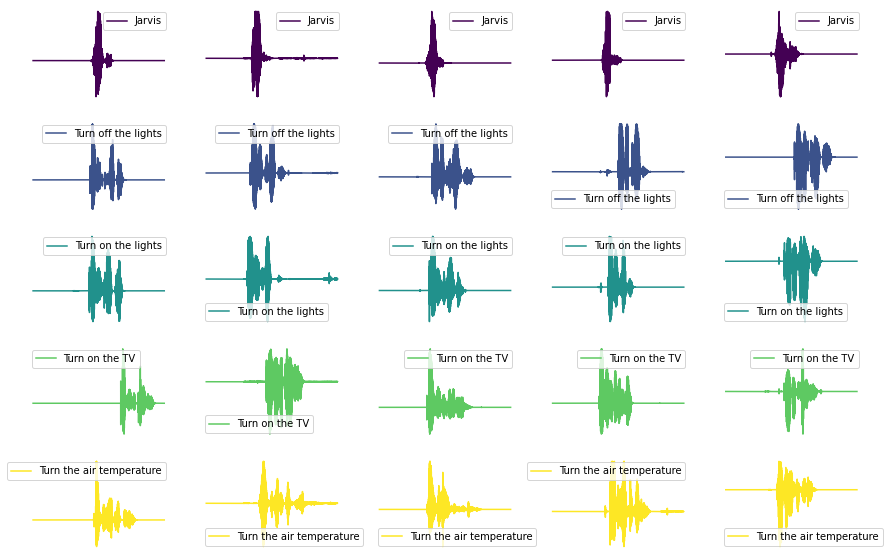

In [ ]:
fig = pl.figure(figsize(15, 10))
wavfiles = []
from pydub import AudioSegment
from pydub.playback import play
for i,f in enumerate(filenames):
    ax = fig.add_subplot(5,5,i+1)
    phrase = AudioSegment.from_wav(f)
    play(phrase)
    wavfiles.append(wav.read(f))
    for k,v in colors.items():
        if k in f: 
            color = colors[k][0]
            label = colors[k][1]
    ax.plot(wavfiles[-1][1], label=label, color=color)
    ax.axis('off')              
    pl.legend()

In [ ]:
import IPython
# Play wave
#wave.play()
IPython.display.Audio(filenames[0]) # This is required on Google Colab due to compatibility issues


Figure 1: 25 sound bites read in as arrays from the original *.wav* file. The arrays represnet sound intensity *vs* time, but the spectral sound information (frequency) is lost.  These are therefore simplified representations of the original data. 
Each of 5 sentences is recorded as spoken by a different person in a different environment: the word "Jarvis", the sentences "Turn off the lights", "Turn on the lights", "Turn on the TV", and "Turn the air temperature".  In the above plot, each row is a different sentence (also plotted with a different color). The content of the soundbite is written on top of the wave plot.  At a glance, the soundbites show some similarities within the same sentence, mostly in the duration of the speech. We also note that the starting point of the speech is not homogeneous within the recorded segment.

The following analysis could be implemented in the full spectral-features dataset, but the current 1-dimensional representation of the data alows for a simpler implementation of the methods.

In [ ]:
wavfiles = np.array([w[1] for w in wavfiles])
print ("the size of the full data set is :", wavfiles.shape)

the size of the full data set is : (25, 64000)


each sound bit is stored in an array of 64000 elements.
We are working with foating point numbers
- 64 bits per number


In [ ]:
print("calculating a distance matrix for the full files would requires " + 
      f"{wavfiles[0].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 8 requires " + 
      f"{wavfiles[0][::8].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 10 requires " + 
      f"{wavfiles[0][::10].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 100 requires " + 
      f"{wavfiles[0][::100].shape[0]**2*64/8e6} MB of memory")

calculating a distance matrix for the full files would requires 32.768 GB of memory
subsampling by a factor 8 requires 0.512 GB of memory
subsampling by a factor 10 requires 0.32768 GB of memory
subsampling by a factor 100 requires 3.2768 MB of memory


In [ ]:
steps = 10

In [ ]:
wavfiles.dtype

dtype('int16')

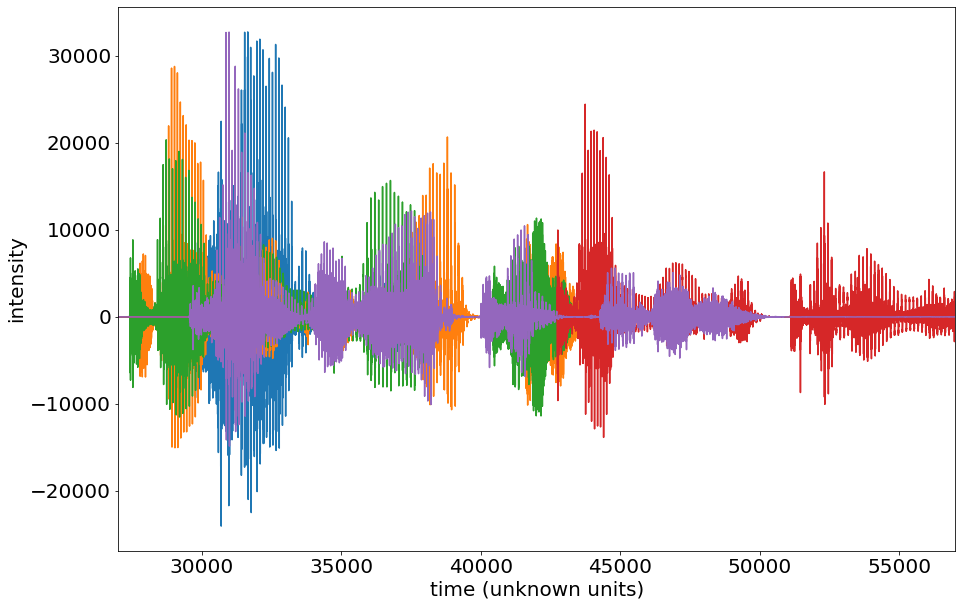

In [ ]:
pl.rcParams['font.size'] = 20
pl.plot(wavfiles[0])
pl.plot(wavfiles[5])
pl.plot(wavfiles[10])
pl.plot(wavfiles[15])
pl.plot(wavfiles[20])
pl.xlim(27000, 57000)
pl.xlabel("time (unknown units)", fontsize=20)
pl.ylabel("intensity", fontsize=20);

Figure 2: the first sound bite for each sentene, the core portion of the array only is shown, elements 27000-57000 of 64000.


## remove from the time series the parts that are just noise

In [ ]:
start, end = 27000, 57000
chunks = 60
newshape= (25*chunks, int((end - start)/chunks))
X = wavfiles[:,start:end].reshape(newshape)
Xcopy = X.copy()
X.shape

(1500, 500)

In [ ]:
i = 2
wavfiles[i,start:start+10]

array([-3414, -3590, -3397, -2610, -1126,   937,  3586,  6967, 10497,
       12271], dtype=int16)

In [ ]:
Xcopy[chunks*i,:10] #- ms[i]

array([-3414, -3590, -3397, -2610, -1126,   937,  3586,  6967, 10497,
       12271], dtype=int16)

# preprocessing (scaling)

In [ ]:
scaler = preprocessing.StandardScaler().fit(Xcopy.T)
X = scaler.transform(Xcopy.T).T

X.std(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
scaler.inverse_transform(X.T).T[chunks*2, :10], \
Xcopy[chunks*2,:10]

(array([-3414., -3590., -3397., -2610., -1126.,   937.,  3586.,  6967.,
        10497., 12271.]),
 array([-3414, -3590, -3397, -2610, -1126,   937,  3586,  6967, 10497,
        12271], dtype=int16))

inspect the sound bites: the original array and the downsampled, normalized ones. 

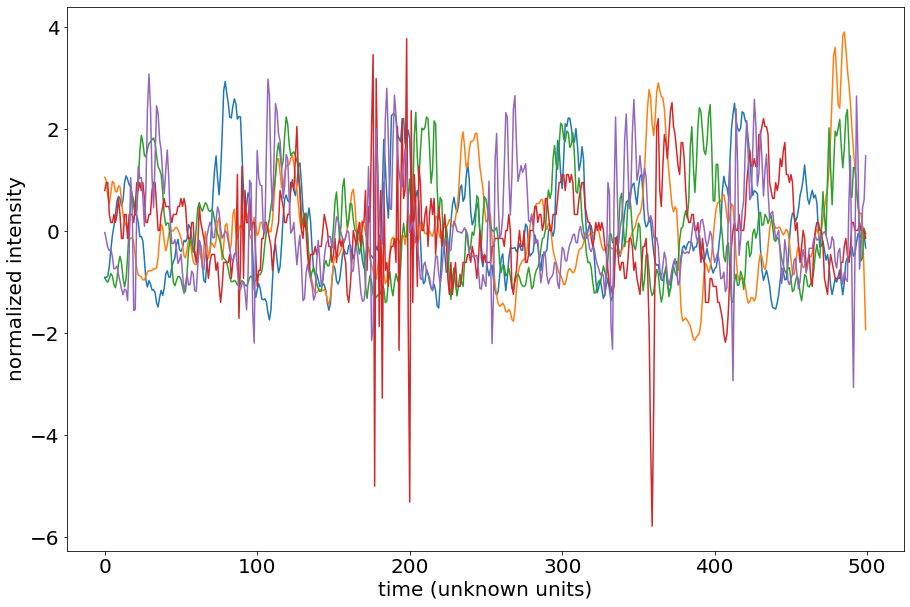

In [ ]:
pl.rcParams['font.size'] = 20
np.random.seed(123)
for i in np.random.randint(1,len(X),5):
  pl.plot(X[i])
#pl.xlim(270, 600)
#pl.ylim(-1e-2,1e-2)
pl.xlabel("time (unknown units)", fontsize=20)
pl.ylabel("normalized intensity", fontsize=20);

Figure 3: Same as figure 2 but for the standardized arrays.

# prepare training / test set

In [ ]:
from sklearn import model_selection
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, X, test_size=0.15)
np.random.seed(10)
test = np.random.randint(0, len(X), 100)
#put a full sound bite in the test set: start at index 360 end at 420
test = np.array(list(set(np.concatenate([test, 
          np.arange(360,420).astype(int)]))))
X_test = X[test]
test


array([   4, 1032,   13,  527,   15,  543,   40,   44,  557,   54, 1078,
        574,   62, 1095,   71, 1097, 1098,   77,  597,   89,   93,  606,
        624,  630, 1146, 1147, 1149,  645,  134, 1159,  652,  653,  655,
        662, 1180,  670, 1206,  185, 1224,  713,  715, 1240,  732,  733,
        232,  746,  747,  749,  239,  755, 1270,  760,  762,  256, 1289,
        780,  783,  283,  796,  801,  290,  818,  825,  313, 1344, 1345,
       1366, 1368,  856,  865,  356,  360,  361,  362, 1387, 1388,  364,
        363,  365,  366, 1393,  367,  371,  368,  369,  370,  372,  373,
        374,  375,  376,  377,  378, 1406,  379,  380,  381,  382,  383,
        384,  385,  386,  387,  388, 1417,  389,  395, 1419,  390,  391,
        392,  393,  394,  396,  397,  398,  399,  406,  919,  400,  409,
        401,  402,  403,  404,  405,  407,  408,  410,  411,  412, 1444,
        413,  414,  415,  416,  417,  418,  419, 1454, 1477, 1485,  974,
       1488, 1492,  472,  480,  490,  502, 1021])

In [ ]:
X_test.shape

(150, 500)

In [ ]:
train = [item for item in range(len(X)) 
            if item not in test]
X_train = X[np.array(train)]
len(X_train)

1350

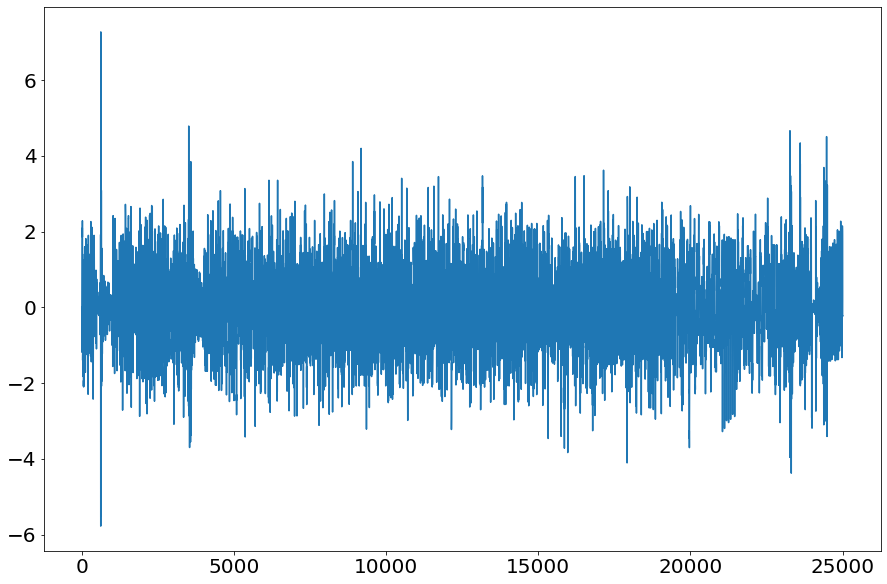

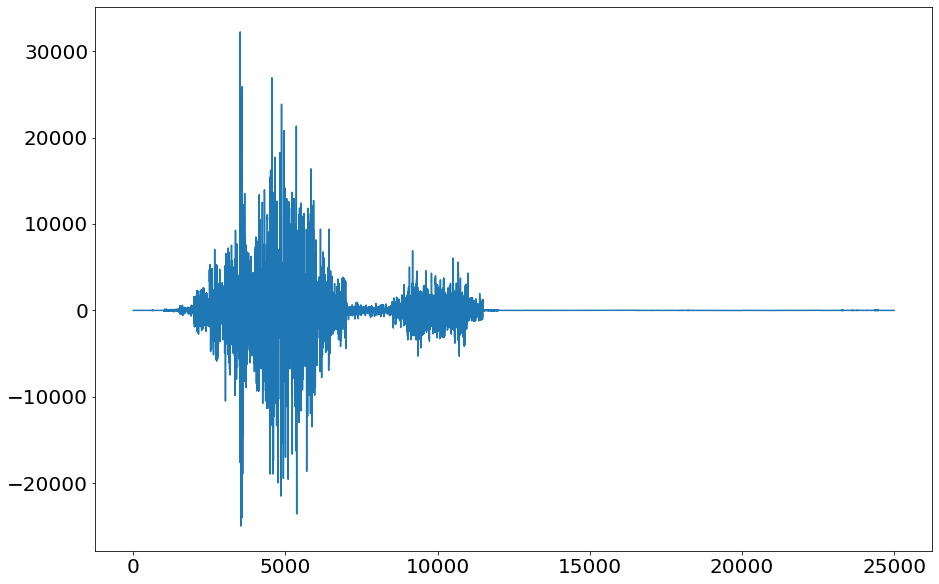

In [ ]:
tmp = np.concatenate([X_test[100+j] for j in range(50)])
pl.plot(tmp)
pl.show()
tmp = np.concatenate([X_test[100+j] * ss[j] + ms[j] for j in range(50)])
pl.plot(tmp)

# Autoencoder

## create the model

In [ ]:
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers

In [ ]:
ndim = X_train[0].shape[0]
model_sound = Sequential()
## encoder
# input layer and the output size
model_sound.add(Dense(128, activation='relu', input_dim=ndim))
#compression layer
model_sound.add(Dense(64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
model_sound.add(Dense(128, activation='relu'))
#output layer, same size as input
model_sound.add(Dense(ndim, activation='linear'))


#alternative syntax
"""
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
"""

NameError: ignored

In [ ]:
model_sound.compile(optimizer="adadelta", loss="mean_squared_error")

In [ ]:
print(model_sound.summary())

## run the model

In [ ]:
history64 = model_sound.fit(X_train, X_train, 
                               validation_data=(X_test, X_test),
                               epochs=500, batch_size=100, verbose=1)

In [ ]:
pl.plot(np.array(history64.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

In [ ]:
model_sound.optimizer.lr

<tf.Variable 'Adadelta/learning_rate:0' shape=() dtype=float32, numpy=0.001>

## second pass

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model_sound.compile(optimizer=opt, 
                    loss="mean_squared_error")


In [ ]:
history64 = model_sound.fit(X_train, X_train, 
                               validation_data=(X_test, X_test),
                               epochs=500, batch_size=100, verbose=1)

Epoch 1/500
14/14 [==============================] - 1s 14ms/step - loss: 0.9218 - val_loss: 0.8921
Epoch 2/500
14/14 [==============================] - 0s 6ms/step - loss: 0.8120 - val_loss: 0.8504
Epoch 3/500
14/14 [==============================] - 0s 6ms/step - loss: 0.7571 - val_loss: 0.8284
Epoch 4/500
14/14 [==============================] - 0s 7ms/step - loss: 0.7186 - val_loss: 0.8099
Epoch 5/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6869 - val_loss: 0.8017
Epoch 6/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6663 - val_loss: 0.7864
Epoch 7/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6486 - val_loss: 0.7836
Epoch 8/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6353 - val_loss: 0.7708
Epoch 9/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6227 - val_loss: 0.7737
Epoch 10/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6136 - val_loss: 0.7697
Epoch 11

Text(0.5, 0, 'iteration')

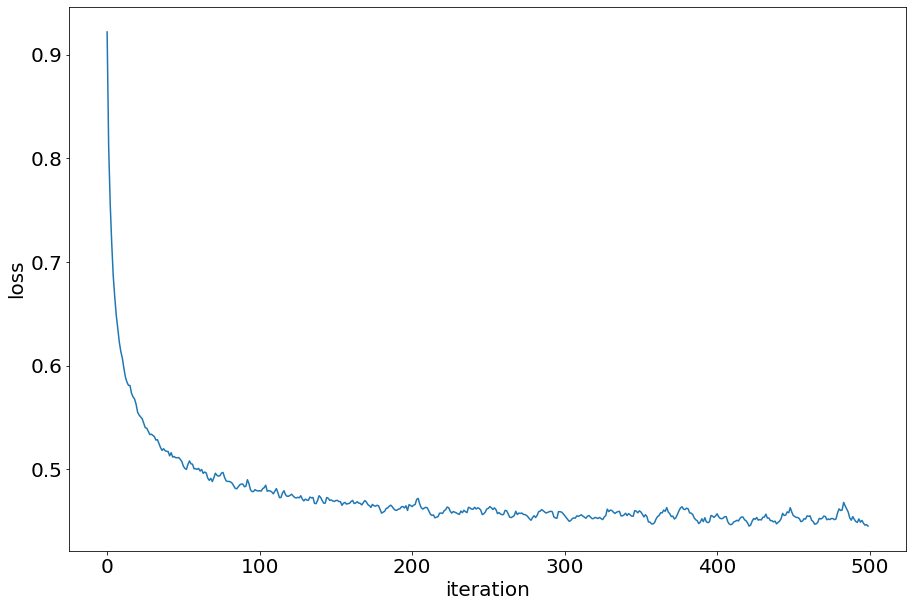

In [ ]:
pl.plot(np.array(history64.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

In [ ]:
opt = keras.optimizers.Adadelta(learning_rate=0.001)

# third pass

Epoch 1/200
14/14 [==============================] - 1s 14ms/step - loss: 0.4885 - val_loss: 0.8065
Epoch 2/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4407 - val_loss: 0.7915
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4210 - val_loss: 0.7870
Epoch 4/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4135 - val_loss: 0.7856
Epoch 5/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4104 - val_loss: 0.7905
Epoch 6/200
14/14 [==============================] - 0s 7ms/step - loss: 0.4089 - val_loss: 0.7934
Epoch 7/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4078 - val_loss: 0.7939
Epoch 8/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4070 - val_loss: 0.7960
Epoch 9/200
14/14 [==============================] - 0s 7ms/step - loss: 0.4067 - val_loss: 0.7998
Epoch 10/200
14/14 [==============================] - 0s 7ms/step - loss: 0.4064 - val_loss: 0.7997
Epoch 11

Text(0.5, 0, 'iteration')

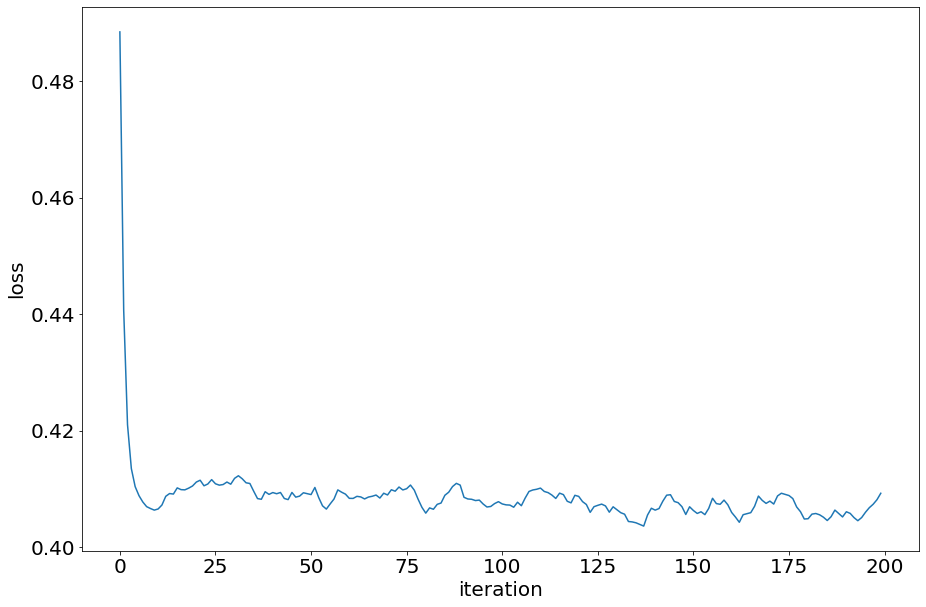

In [ ]:
keras.backend.clear_session()
opt = keras.optimizers.Adam(learning_rate=0.005)
model_sound.compile(optimizer=opt, loss="mean_squared_error")
history64 = model_sound.fit(X_train, X_train, 
                               validation_data=(X_test, X_test),
                               epochs=200, batch_size=100, verbose=1)
pl.plot(np.array(history64.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

## results

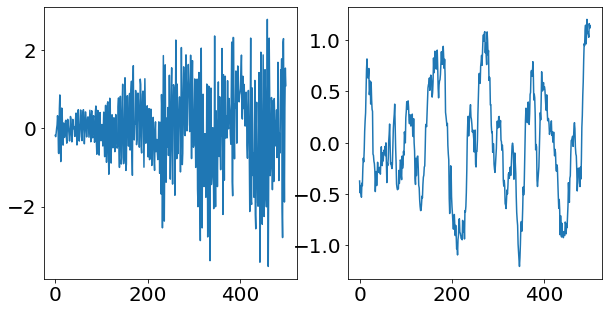

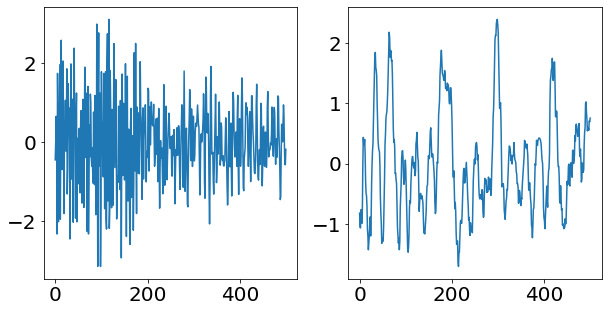

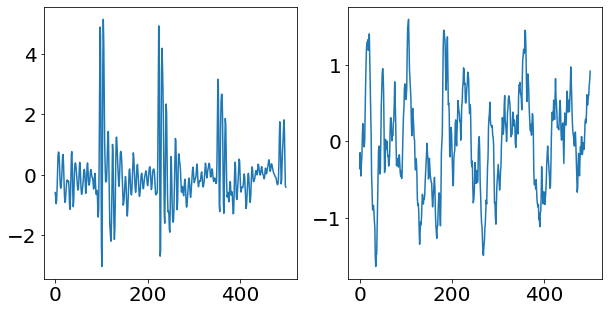

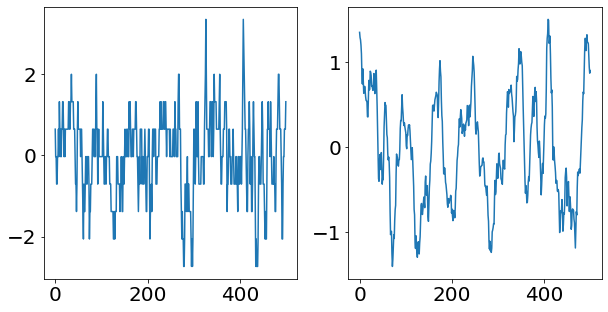

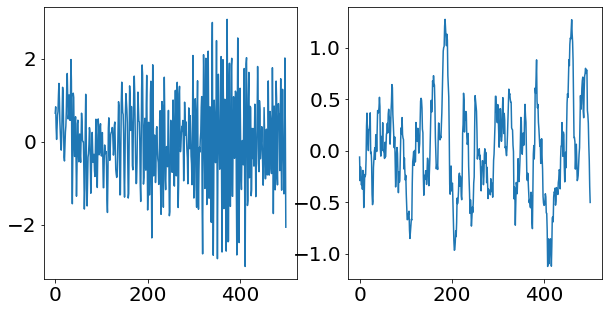

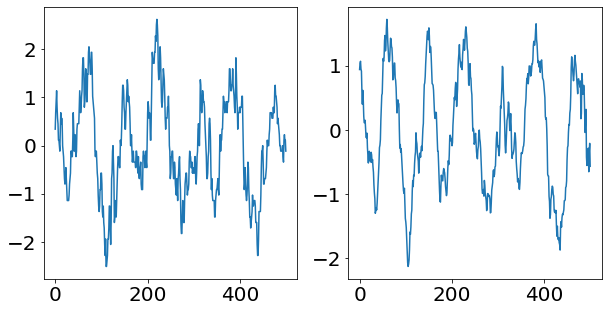

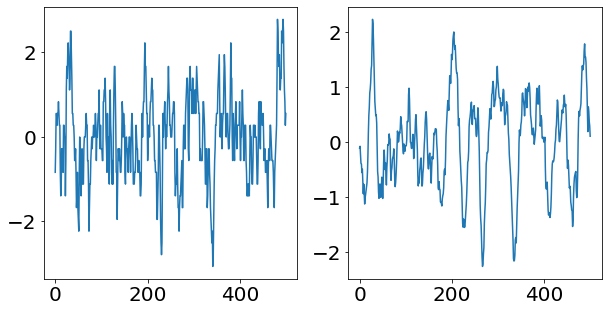

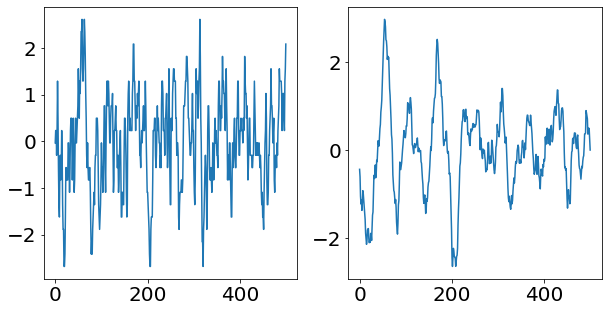

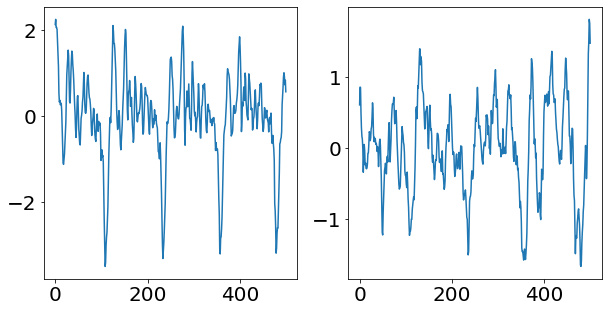

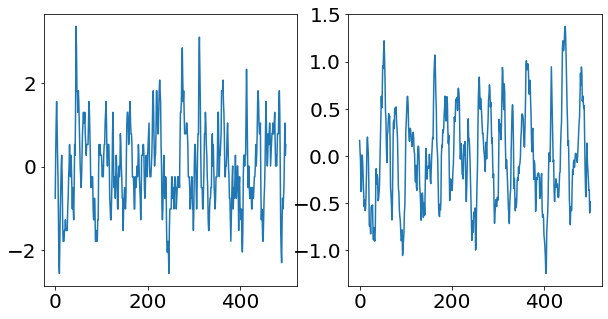

In [ ]:
output = model_sound.predict(X_test)

def compareinout(i, out):
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(121) 
  ax.plot(X_test[i])
  ax = fig.add_subplot(122) 
  ax.plot(out[i])
  pl.show()

np.random.seed(123)
for i in range(10):
  compareinout(i, output)
  

In [ ]:
Xrecopy = X.copy()
X[test] = output
X = scaler.inverse_transform(X.T).T


In [ ]:
i=6
samplerate = 17640

import scipy
scipy.io.wavfile.write("test.wav", samplerate, 
                       (wavfiles[i,27000:57000]))
IPython.display.Audio("test.wav") # This is required on Google Colab due to compatibility issues


In [ ]:
import scipy 
scipy.io.wavfile.write("test1.wav", samplerate, 
                       np.concatenate([Xcopy[i]  for i in range(chunks*i, 
                                                                chunks*(i+1))]).astype(np.int16))
IPython.display.Audio("test1.wav") # This is required on Google Colab due to compatibility issues


In [ ]:
samplerate = 17640
import scipy 
tmp = np.concatenate([X[j]  for j in range(chunks*i, 
                          chunks*(i+1))]).astype(np.int16)

scipy.io.wavfile.write("test2.wav", samplerate, tmp)
                       
IPython.display.Audio("test2.wav") # This is required on Google Colab due to compatibility issues


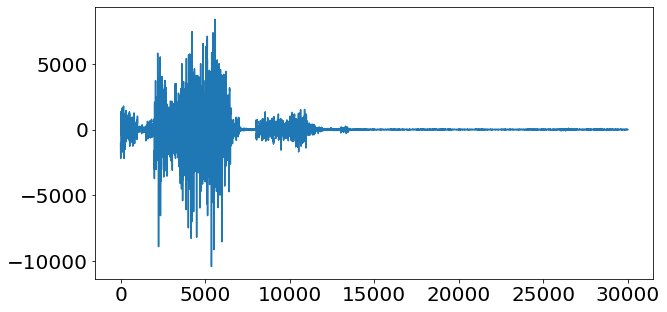

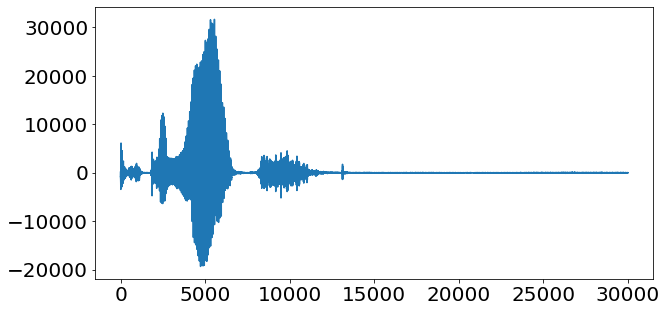

In [ ]:
pl.plot(tmp)
pl.show()
pl.plot(wavfiles[i,27000:57000])
